In [1]:
# %load basic_example_G.py
import src.core as mlApi

Using TensorFlow backend.


In [2]:
# 1. Define dataset specifics

# File path to dataset .csv file
filename = "../master-thesis-db/datasets/G/data_30min.csv"

# List of columns on form ['name', 'desc', 'unit']
columns = [
	['PDI0064', 'Process side dP', 'bar'],
	['TI0066', 'Process side Temperature out','degrees'],
	['TZI0012', 'Process side Temperature in', 'degrees'],
	['FI0010', 'Process side flow rate', 'MSm^3/d(?)'],
	['TT0025', 'Cooling side Temperature in', 'degrees'],
	['TT0026', 'Cooling side Temperature out', 'degrees'],
	['PI0001', 'Cooling side Pressure in', 'barG'],
	['FI0027', 'Cooling side flow rate', 'MSm^3/d(?)'],
	['TIC0022U', 'Cooling side valve opening', '%'],
	['PDT0024', 'Cooling side dP', 'bar'],
]

# List of column names to ignore completely
irrelevantColumns = [
	'PI0001',
	'FI0027',
	'TIC0022U',
	'PDT0024',
]

# List of column names used a targets
targetColumns = [
	'TT0026',
    'PDI0064',
]

# List of training periods on form ['start', 'end']
traintime = [
	["2019-04-10 00:00:00", "2019-08-01 00:00:00"]
]

# Testing period, recommended: entire dataset
testtime = [
	"2017-01-01 00:00:00",
	"2020-03-01 00:00:00",
]

In [3]:
# 2. Initiate and divide data

df = mlApi.initDataframe(filename, columns, irrelevantColumns)
df_train, df_test = mlApi.getTestTrainSplit(traintime, testtime)
X_train, y_train, X_test, y_test = mlApi.getFeatureTargetSplit(targetColumns)

Columns before removal: 
Col. 0 : PDI0064 - Process side dP
Col. 1 : TI0066 - Process side Temperature out
Col. 2 : TZI0012 - Process side Temperature in
Col. 3 : FI0010 - Process side flow rate
Col. 4 : TT0025 - Cooling side Temperature in
Col. 5 : TT0026 - Cooling side Temperature out
Col. 6 : PI0001 - Cooling side Pressure in
Col. 7 : FI0027 - Cooling side flow rate
Col. 8 : TIC0022U - Cooling side valve opening
Col. 9 : PDT0024 - Cooling side dP

Columns after removal: 
Col. 0 : PDI0064 - Process side dP
Col. 1 : TI0066 - Process side Temperature out
Col. 2 : TZI0012 - Process side Temperature in
Col. 3 : FI0010 - Process side flow rate
Col. 4 : TT0025 - Cooling side Temperature in
Col. 5 : TT0026 - Cooling side Temperature out

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows



In [4]:
# 3. Define models

mlpd_1x_128 = mlApi.MLP('mlpd 1x 128', layers=[128], dropout=0.2)
lstmd_1x_128 = mlApi.LSTM('lstmd 1x 128', layers=[128], dropout=0.2, recurrentDropout=0.2, enrolWindow=16)
mlpd_2x_64 = mlApi.MLP('mlpd 2x 64', layers=[64, 64], dropout=0.2)
lstmd_2x_64 = mlApi.LSTM('lstmd 2x 64', layers=[64, 64], dropout=0.2, recurrentDropout=0.2, enrolWindow=16)
linear_r = mlApi.Linear_Regularized('linear r')
ensemble1 = mlApi.Ensemble('mlp2 + linear ensemble', [mlpd_2x_64, linear_r])
ensemble2 = mlApi.Ensemble('lstm2 + mlp2 ensemble', [mlpd_2x_64, lstmd_2x_64])

modelList = [
    mlpd_1x_128,
    lstmd_1x_128,
	mlpd_2x_64,
	lstmd_2x_64,
    ensemble1,
    ensemble2,
	linear_r,
]

Model mlpd 1x 128 was loaded from file
Model lstmd 1x 128 was loaded from file
Model mlpd 2x 64 was loaded from file
Model lstmd 2x 64 was loaded from file
Model mlp2 + linear ensemble was loaded from file
Training submodel linear r of Ensemble mlp2 + linear ensemble
Model lstm2 + mlp2 ensemble was loaded from file
Model lstm2 + mlp2 ensemble was loaded from file
Training model linear r
+--------------+-----------+-------------+---------------+--------+
|    Model     | Min. loss | Chosen loss | Min. val loss | Epochs |
+--------------+-----------+-------------+---------------+--------+
| mlpd 1x 128  |  0.228337 |   0.684058  |    1.213786   |  301   |
| lstmd 1x 128 |  0.003289 |   0.031115  |    0.213079   |  119   |
|  mlpd 2x 64  |  0.177643 |   0.366033  |    1.890415   |  301   |
| lstmd 2x 64  |  0.003061 |   0.020474  |    0.215791   |   76   |
+--------------+-----------+-------------+---------------+--------+


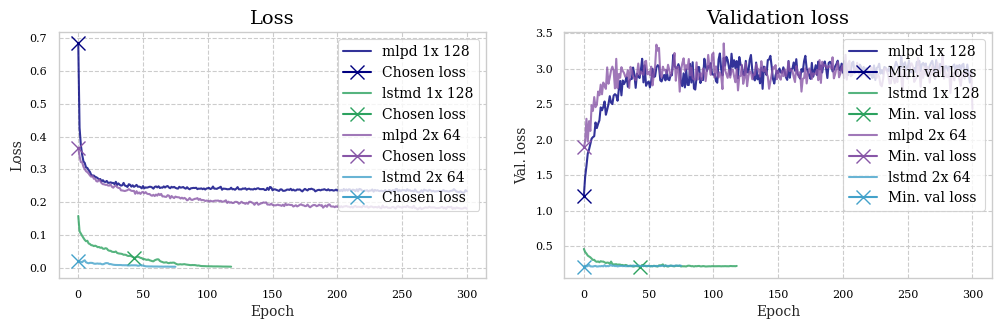

In [5]:
# 4. Initiate and train models

# Define whether to retrain models or not
retrain=False

mlApi.initModels(modelList)
mlApi.trainModels(retrain)

Model prediction scores
+------------------------+-------------+------------+
|         Model          | Train score | Test score |
+------------------------+-------------+------------+
|      mlpd 1x 128       |    0.3991   |  -0.7978   |
|      lstmd 1x 128      |    0.784    |  -0.9907   |
|       mlpd 2x 64       |    0.3896   |  -1.3923   |
|      lstmd 2x 64       |    0.7865   |  -0.9993   |
| mlp2 + linear ensemble |    0.5937   |  -1.4159   |
| lstm2 + mlp2 ensemble  |    0.8336   |  -1.1393   |
|        linear r        |    0.4868   |  -0.9427   |
+------------------------+-------------+------------+


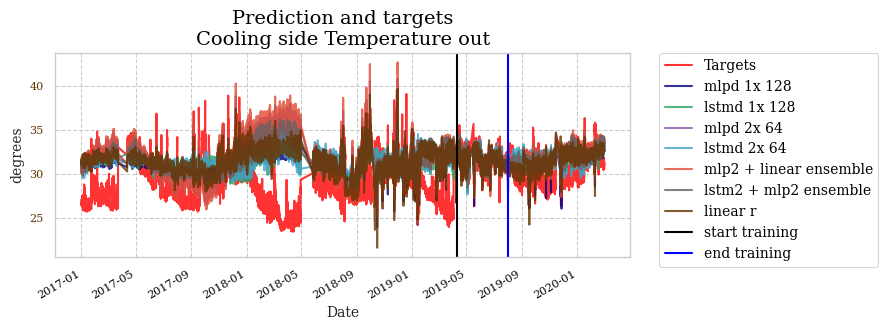

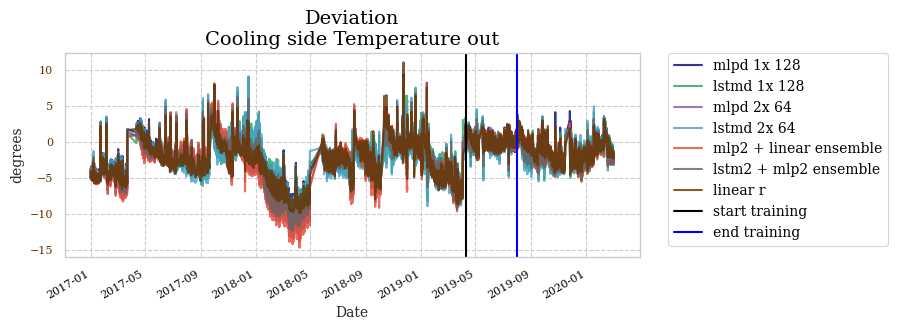

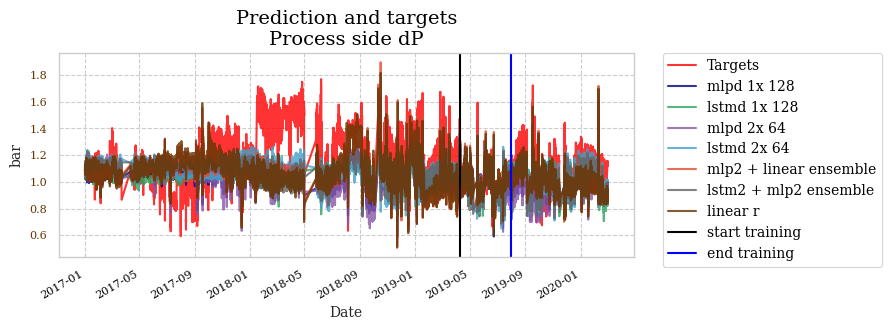

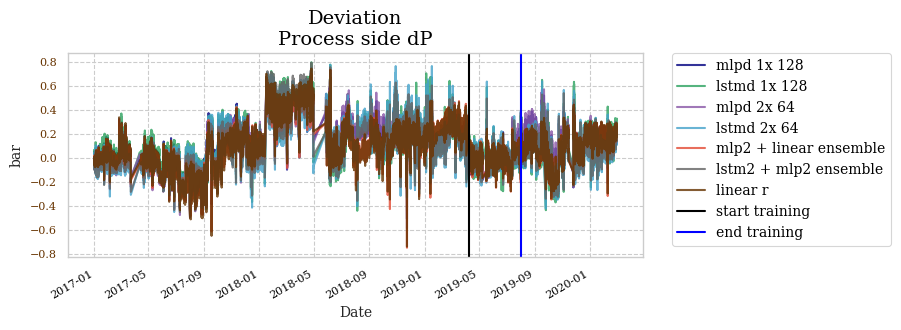

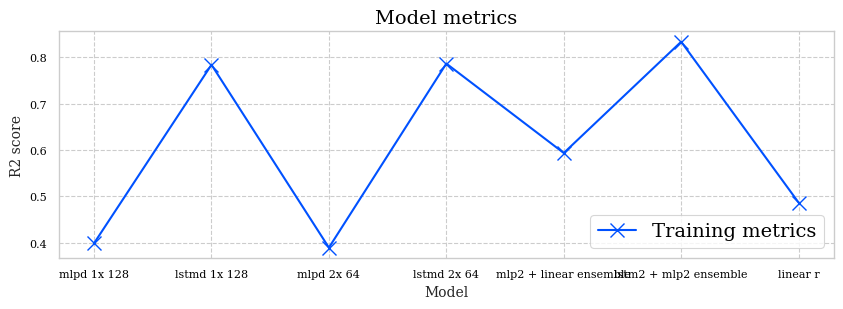

In [6]:
modelNames, metrics_train, metrics_test, columnsList, deviationsList = mlApi.predictWithModels(
	plot=True,
	interpol=False,
	score=True,
)

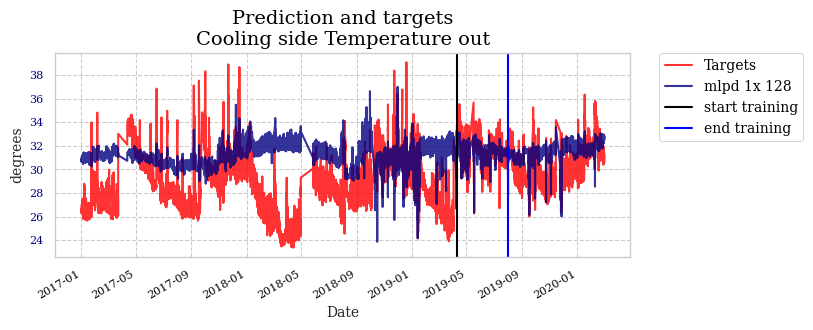

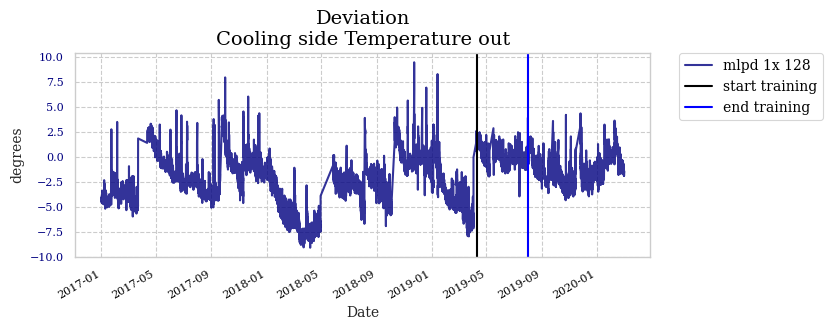

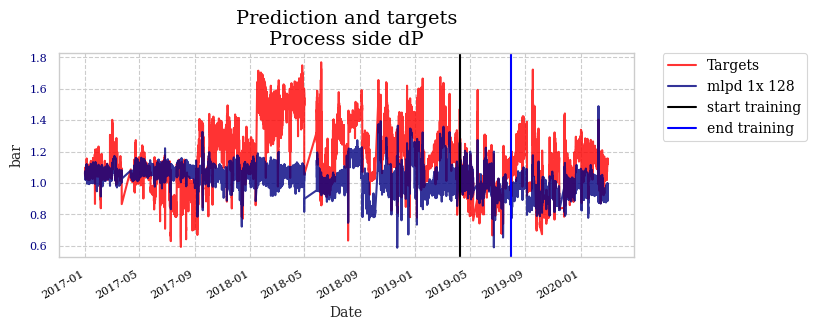

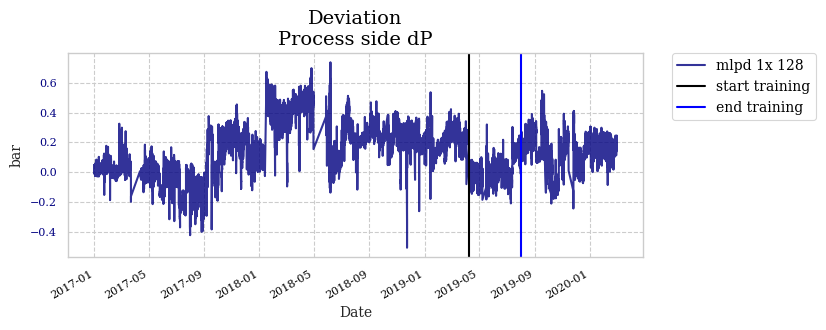

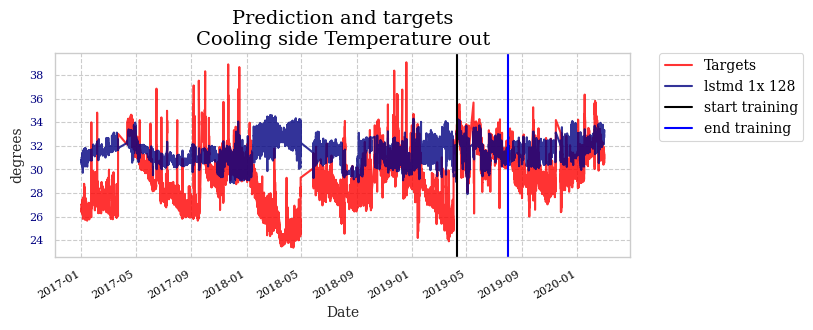

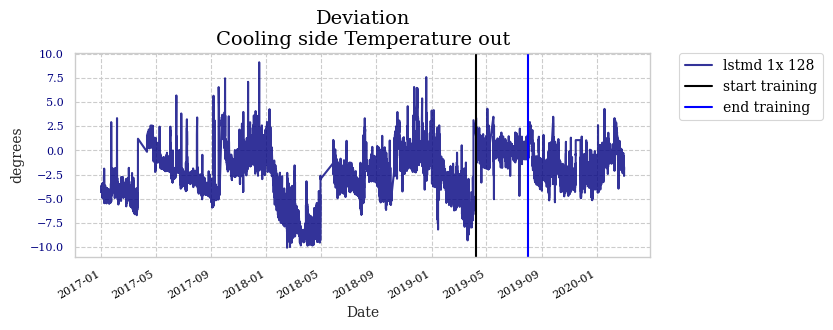

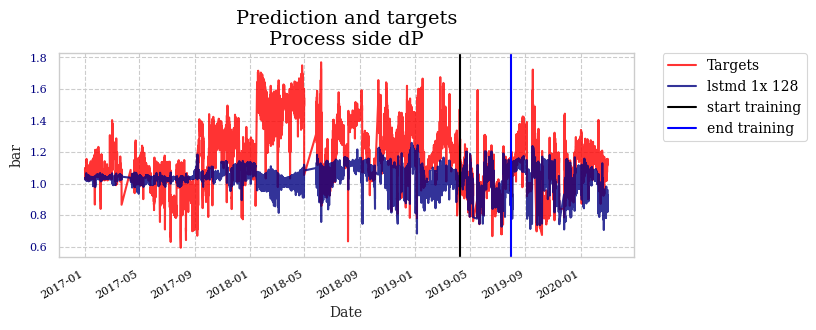

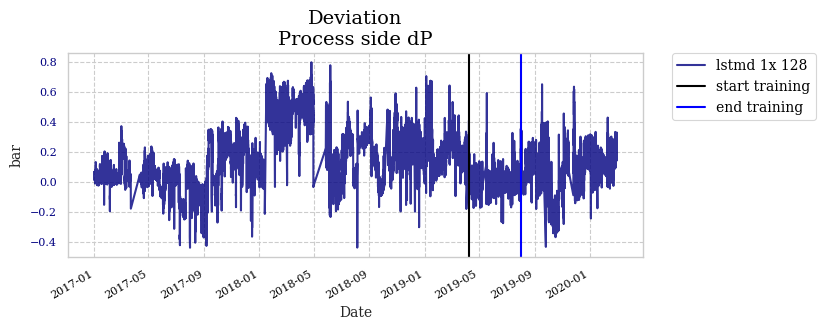

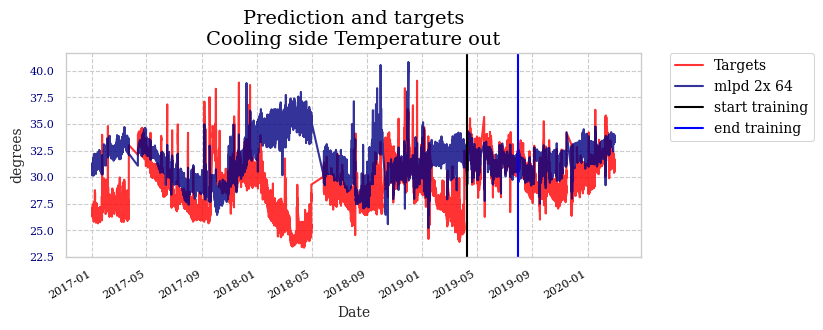

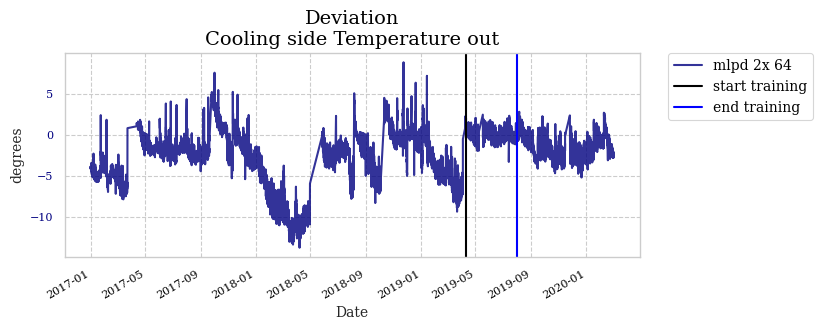

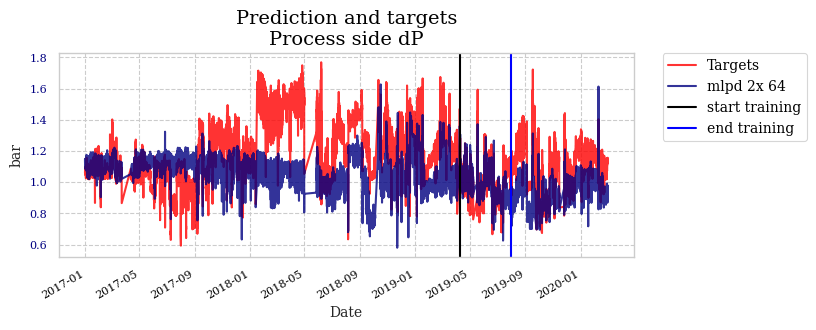

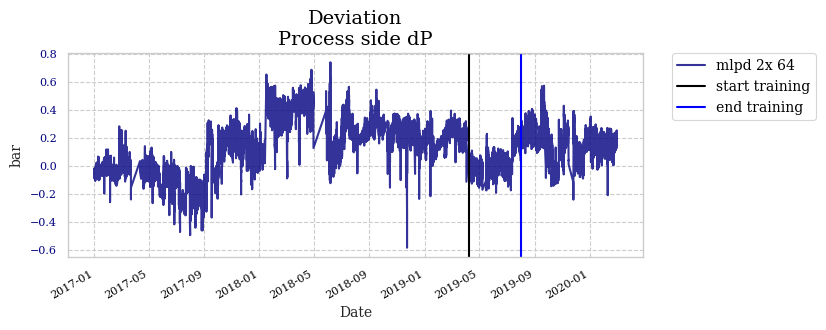

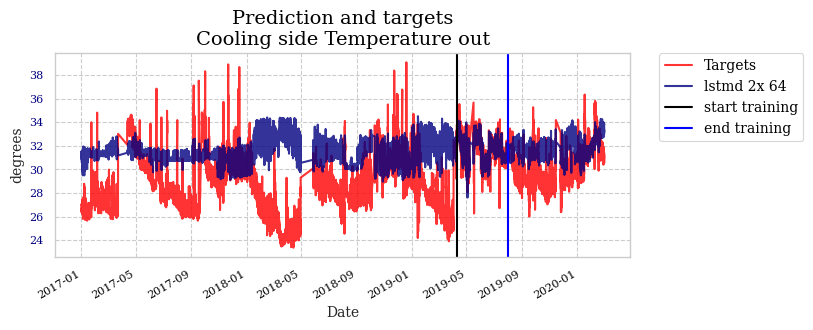

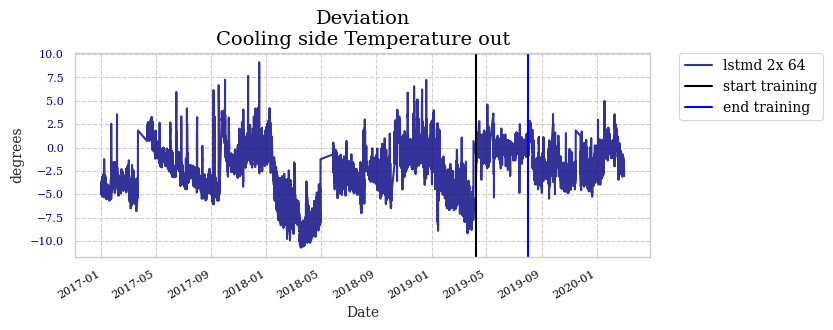

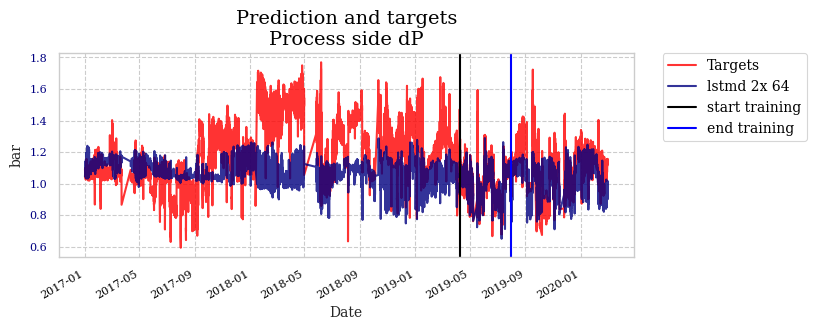

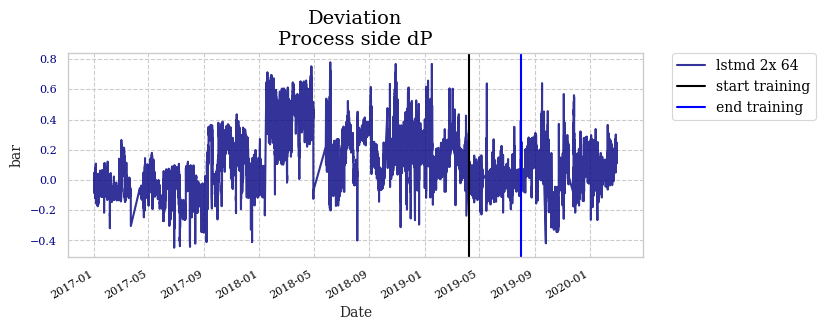

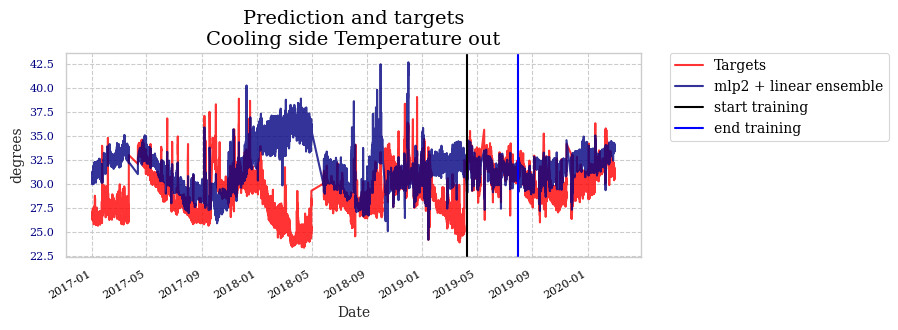

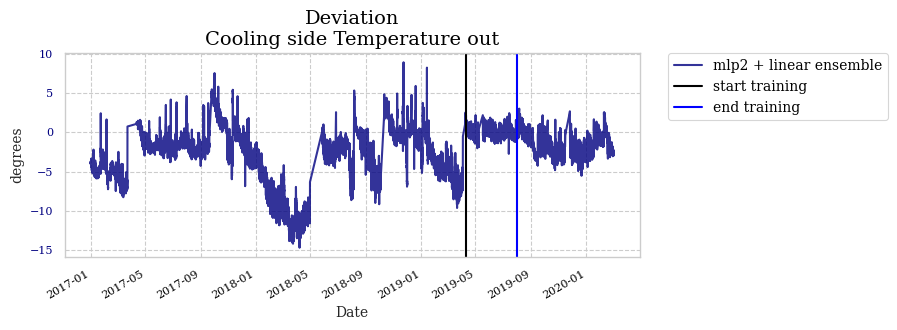

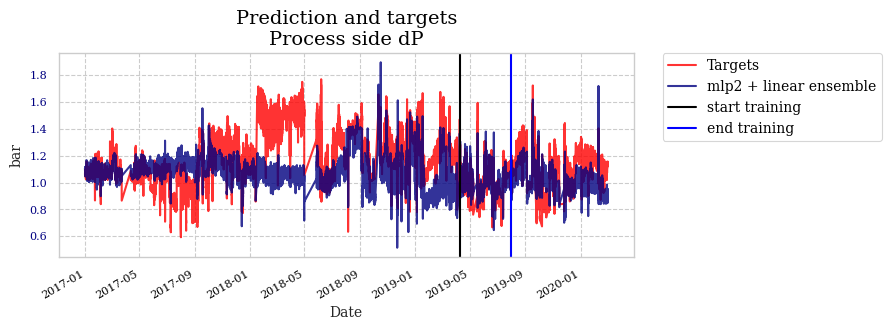

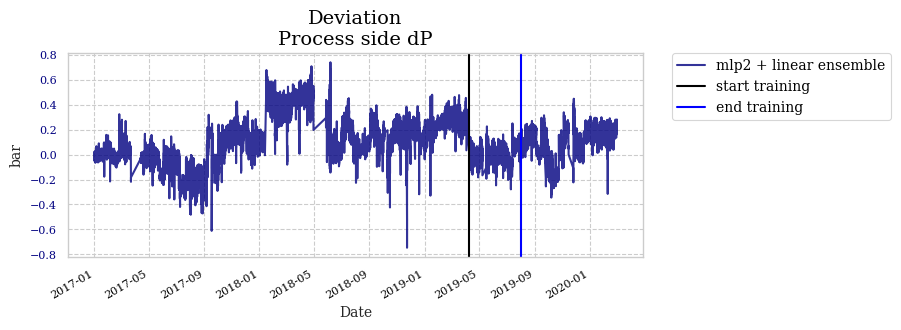

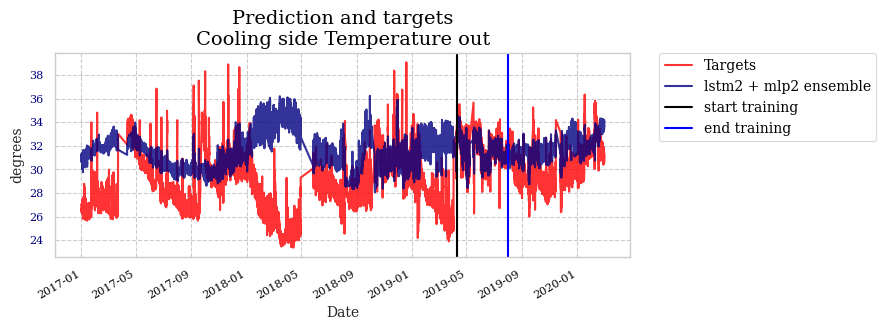

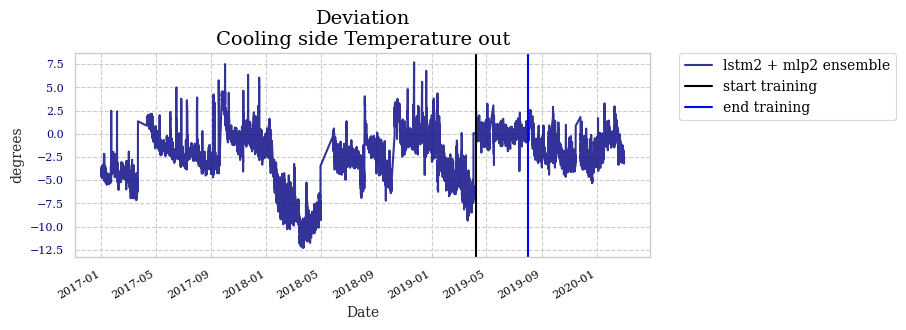

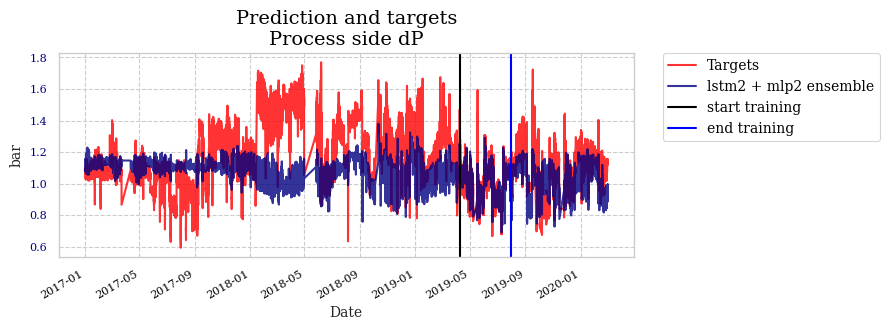

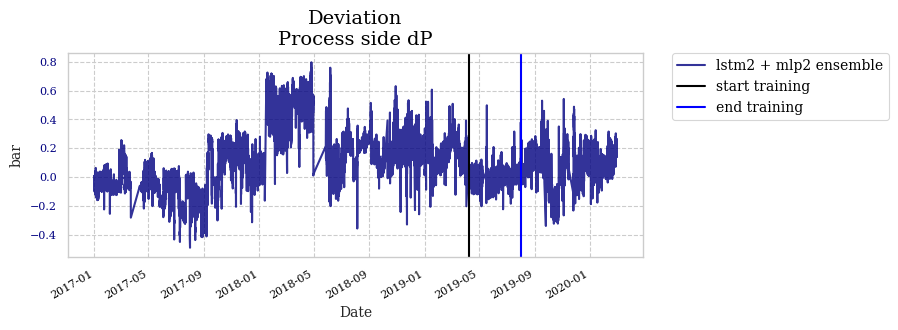

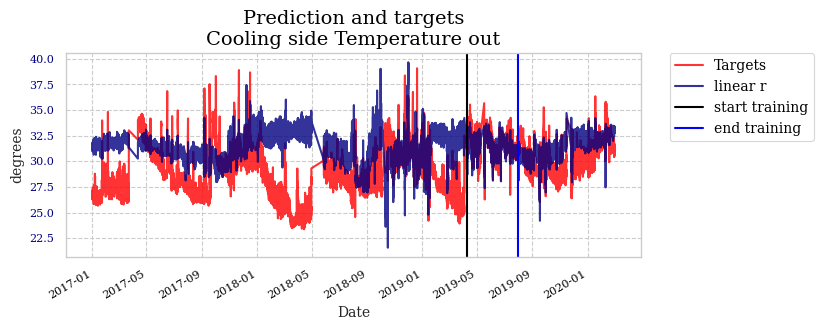

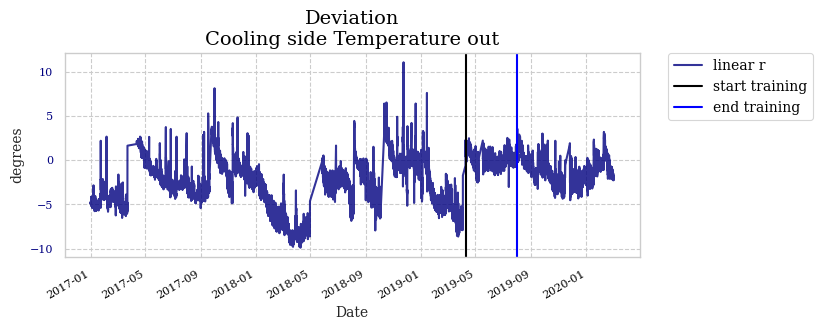

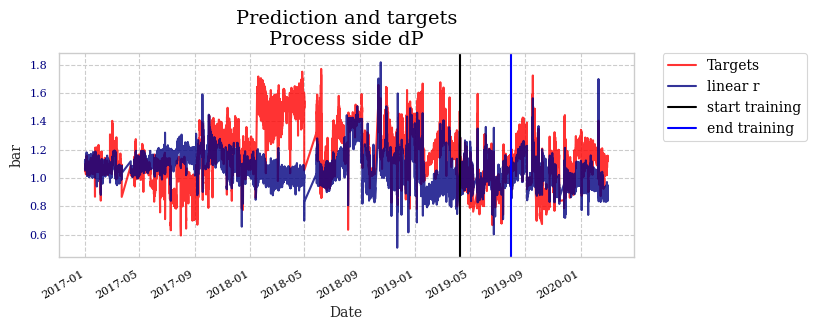

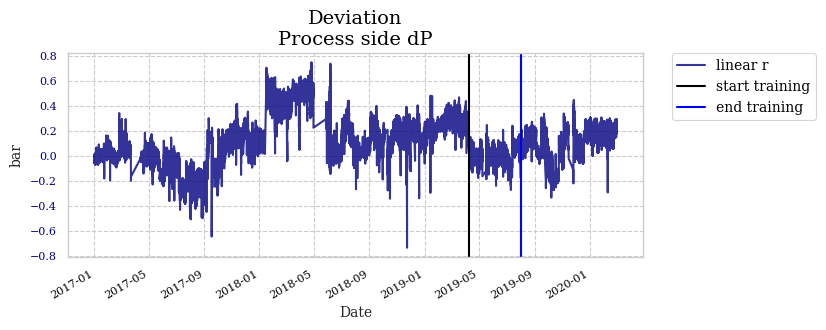

In [7]:
for model in modelList:
    mlApi.initModels([model])
    modelNames, metrics_train, metrics_test, columnsList, deviationsList = mlApi.predictWithModels(
        plot=True,
        interpol=False,
        score=False,
    )